In [2]:
%load_ext autoreload
%autoreload 2

from ocean_navigation_simulator.generative_error_model.generative_model_metrics import rmse_over_time_xr, rmse_over_time, vector_correlation_over_time_xr, vector_correlation_over_time
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd

## Compare RMSE

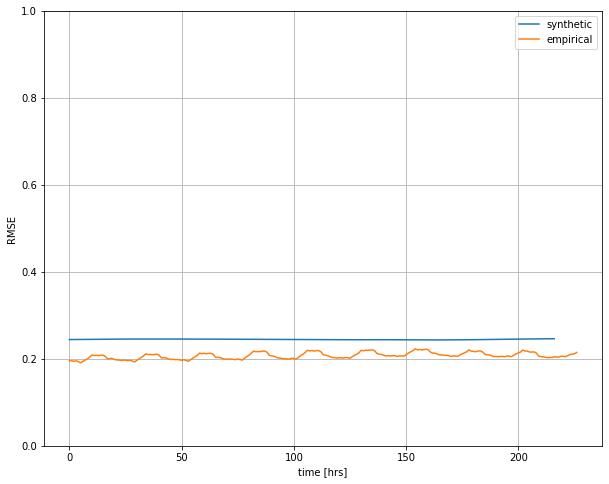

In [17]:
#synthetic
error_data_root = "/home/jonas/Documents/Thesis/OceanPlatformControl/data/drifter_data/synthetic_error/area1"
files = os.listdir(error_data_root)
rmse = []
for file in files:
    data = xr.open_dataset(os.path.join(error_data_root, file), engine="netcdf4")
    rmse.append(rmse_over_time_xr(data, variables=("water_u", "water_v")))
rmse = np.array(rmse).mean(axis=0)

fig = plt.figure(figsize=(10,8))
plt.plot(range(len(rmse)), rmse, label="synthetic")

# empirical
error_data_root = "/home/jonas/Documents/Thesis/OceanPlatformControl/data/drifter_data/dataset_forecast_error/area1_edited"
files = sorted(os.listdir(error_data_root))
rmse_data = []
for file in files[:50]:
    data = pd.read_csv(os.path.join(error_data_root, file))
    rmse_data.append(rmse_over_time(data, variables=("u_error", "v_error"))["rmse"])
# take average for each hour
rmse_data = np.array(rmse_data).mean(axis=0)

plt.plot(range(len(rmse_data)), rmse_data, label="empirical")
plt.ylim([0, 1.0])
# plt.title("Empirical RMSE vs Synthetic RMSE")
plt.ylabel("RMSE")
plt.xlabel("time [hrs]")
plt.grid()
plt.legend()

## Compute Synthetic Vector Correlation

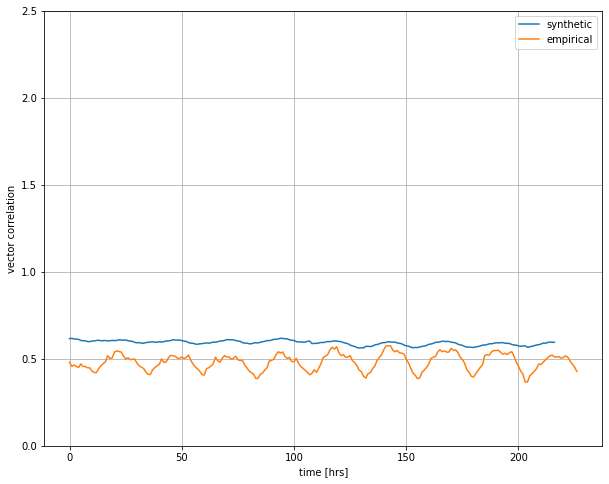

In [18]:
# synthetic
# forecast + synth error vs forecast
error_data_root = "/home/jonas/Documents/Thesis/OceanPlatformControl/data/drifter_data/synthetic_error/area1"
error_files = sorted(os.listdir(error_data_root))

forecast_root = "/home/jonas/Documents/Thesis/OceanPlatformControl/data/drifter_data/forecasts/area1"
forecast_files = sorted(os.listdir(forecast_root))[:len(error_files)]

vec_corr = []
for error_file, forecast_file in zip(error_files, forecast_files):
    error_data = xr.open_dataset(os.path.join(error_data_root, error_file))
    forecast_data = xr.open_dataset(os.path.join(forecast_root, forecast_file))
    temp_vec_corr = vector_correlation_over_time_xr(error_data, forecast_data)
    vec_corr.append(temp_vec_corr)
vec_corr = np.array(vec_corr).mean(axis=0)

fig = plt.figure(figsize=(10,8))
plt.plot(range(len(vec_corr)), vec_corr, label="synthetic")

# empirical
# use forecast error + forecast or alternatively buoy data directly
# use forecast+error vs forecast
forecast_error_root = "/home/jonas/Documents/Thesis/OceanPlatformControl/data/drifter_data/dataset_forecast_error/area1_edited"
error_files = sorted(os.listdir(forecast_error_root))[:20]
vec_corr = []
for file in error_files:
    data = pd.read_csv(os.path.join(forecast_error_root, file))
    vec_corr.append(vector_correlation_over_time(data))
vec_corr = np.array(vec_corr).mean(axis=0)

plt.plot(range(len(vec_corr)), vec_corr, label="empirical")
plt.ylim([0, 2.5])
# plt.title("Empirical Vector Correlation vs Synthetic Vector Correlation")
plt.xlabel("time [hrs]")
plt.ylabel("vector correlation")
plt.grid()
plt.legend()

## Sample from Simplex Noise Sample and compute Variogram

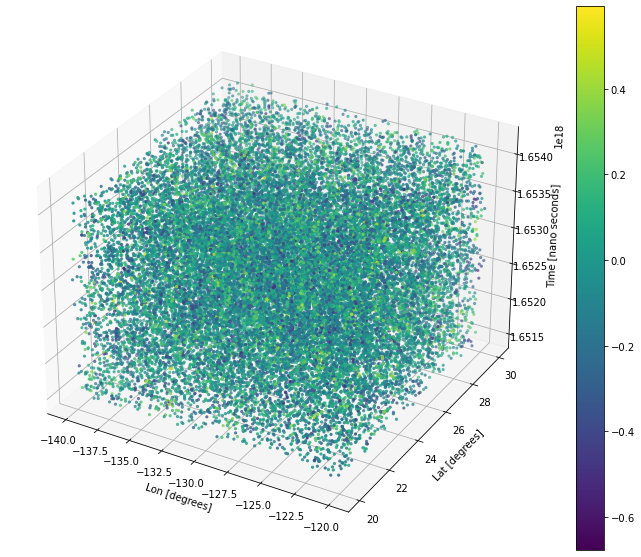

In [19]:
import os
import xarray as xr
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


data = xr.load_dataset("/home/jonas/Downloads/test_noise.nc")
# data = xr.load_dataset("/home/jonas/Documents/Thesis/OceanPlatformControl/data/drifter_data/sampled_noise.nc")
lon_len = len(data["lon"].values)
lat_len = len(data["lat"].values)
time_len = len(data["time"].values)
total_len = lon_len * lat_len * time_len

idx = np.random.choice(list(range(total_len)), size=30000)

lon = data["lon"].values.reshape(-1)
lat = data["lat"].values.reshape(-1)
time = data["time"].values.reshape(-1)

axes = np.array(list(itertools.product(time, lat, lon)))[idx]
time = axes[:, 0]
lat = axes[:, 1]
lon = axes[:, 2]
u_error = data["water_u"].values.reshape(-1)[idx]
v_error = data["water_v"].values.reshape(-1)[idx]

data = pd.DataFrame({"lon": lon,
                     "lat": lat,
                     "time": time,
                     "u_error": u_error,
                     "v_error": v_error})

time_plot = np.array(time, dtype=np.int64)

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(projection="3d")
plot = ax.scatter(lon, lat, time_plot, c=u_error, marker=".")
ax.set_xlabel("Lon [degrees]")
ax.set_ylabel("Lat [degrees]")
ax.set_zlabel("Time [nano seconds]")
plt.colorbar(plot, ax=ax)

In [21]:
from ocean_navigation_simulator.generative_error_model.variogram.Variogram import Variogram
from ocean_navigation_simulator.generative_error_model.variogram.VisualizeVariogram import VisualizeVariogram

print(data)
v = Variogram(data)
v.detrend()
bins, bins_count = v.build_variogram((5, 1), num_workers=2, chunk_size=int(1e6), cross_buoy_pairs_only=False, is_3d=False)

              lon        lat                time   u_error   v_error
0     -134.916667  22.833333 2022-05-05 11:30:00  0.001919 -0.176675
1         -123.25  21.166667 2022-05-25 06:30:00  0.131318 -0.181624
2     -129.333333      29.75 2022-05-09 04:30:00 -0.271843 -0.177124
3     -126.416667       20.5 2022-05-29 16:30:00 -0.176875 -0.142399
4     -121.166667       29.0 2022-05-06 21:30:00  0.135672 -0.437542
...           ...        ...                 ...       ...       ...
29995 -125.083333       24.5 2022-05-16 20:30:00 -0.196970  0.181338
29996 -135.416667  29.916667 2022-05-31 10:30:00  0.192126 -0.167075
29997     -130.75  24.083333 2022-05-18 08:30:00  0.016995 -0.166273
29998 -135.583333  27.666667 2022-05-07 11:30:00  0.006548  0.040421
29999 -139.833333  22.166667 2022-05-23 23:30:00 -0.075297 -0.198079

[30000 rows x 5 columns]


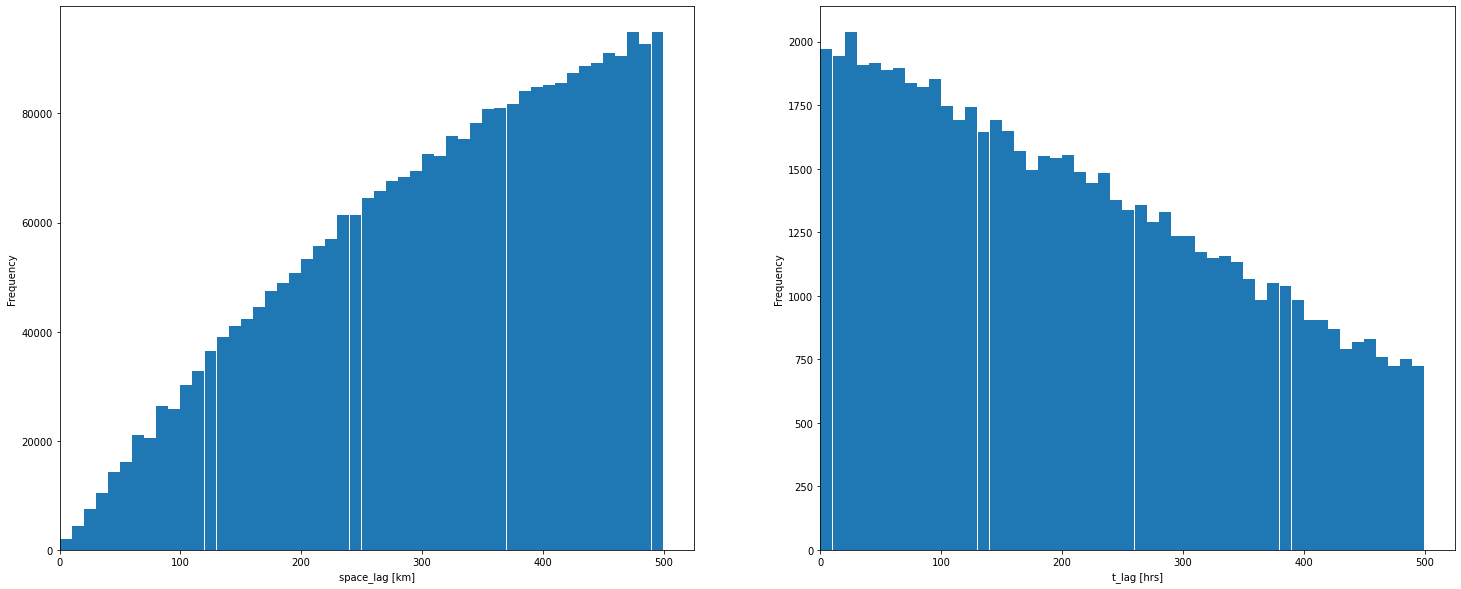

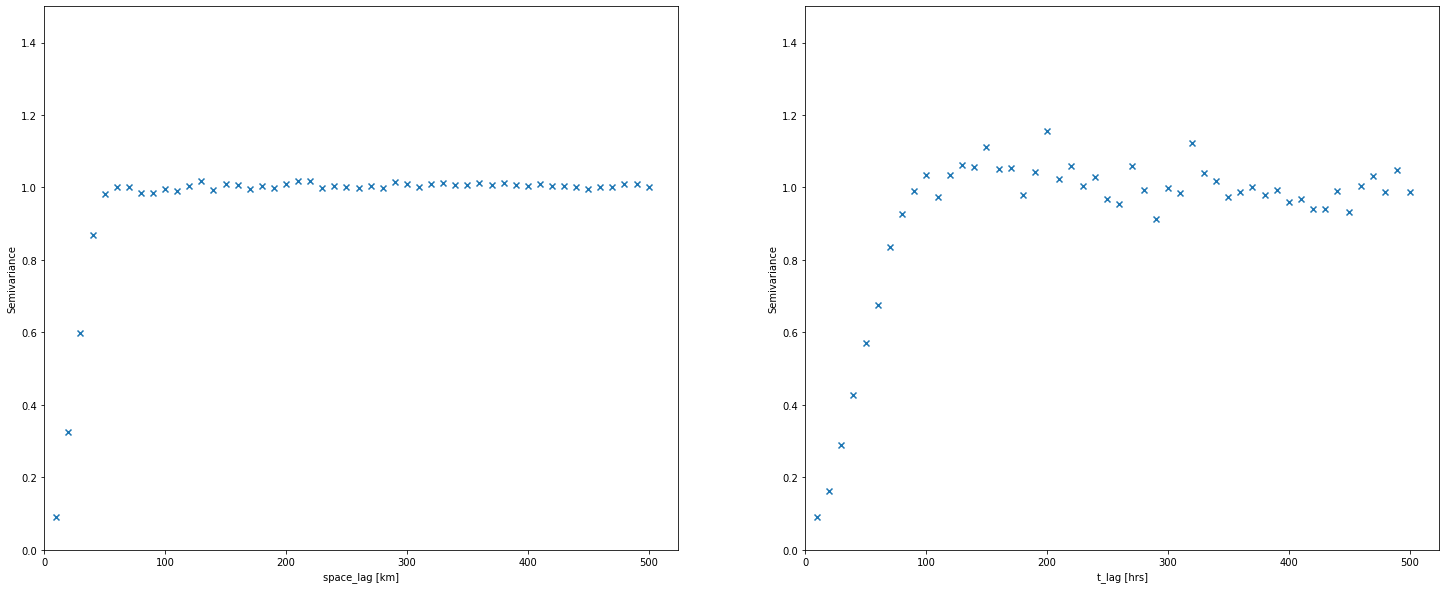

In [24]:
vvis = VisualizeVariogram(variogram=v)
vvis.decrease_variogram_res((10, 10))
view_range = [500, 500]
vvis.plot_histograms(view_range=view_range)
vvis.plot_variograms(error_variable="u", view_range=view_range)

## Compute stats of opensimplex

In [34]:
import opensimplex
import numpy as np

simplex_gen = opensimplex.OpenSimplex(seed=12345678)
num_pts = int(2e2)
num_of_loops = 100
means = []
sum = 0
sumsq = 0
for i in range(num_of_loops):
    rand_x = np.random.uniform(0, 1000, num_pts)
    rand_y = np.random.uniform(0, 1000, num_pts)
    rand_z = np.random.uniform(0, 1000, num_pts)
    rand_t = np.random.uniform(0, 1000, num_pts)
    samples = np.array(simplex_gen.noise3array(rand_x, rand_y, rand_z))
    means.append(samples.mean())
    sum += samples.sum()
    sumsq += np.square(samples).sum()

print(np.array(means).mean())
print((sumsq - (sum * sum)/(num_of_loops*num_pts**3))/(num_of_loops*num_pts**3))

-7.076037679000259e-06
0.09792579099296904
